In [12]:
# Gerekli kütüphanelerin yüklenmesi

import numpy as np
import pandas as pd
import scipy.stats as st
pd.set_option('display.max_columns', None)

import math

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', palette='Blues')

import missingno as msno

from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.metrics import r2_score, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data = pd.read_csv('vgsales.csv')
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


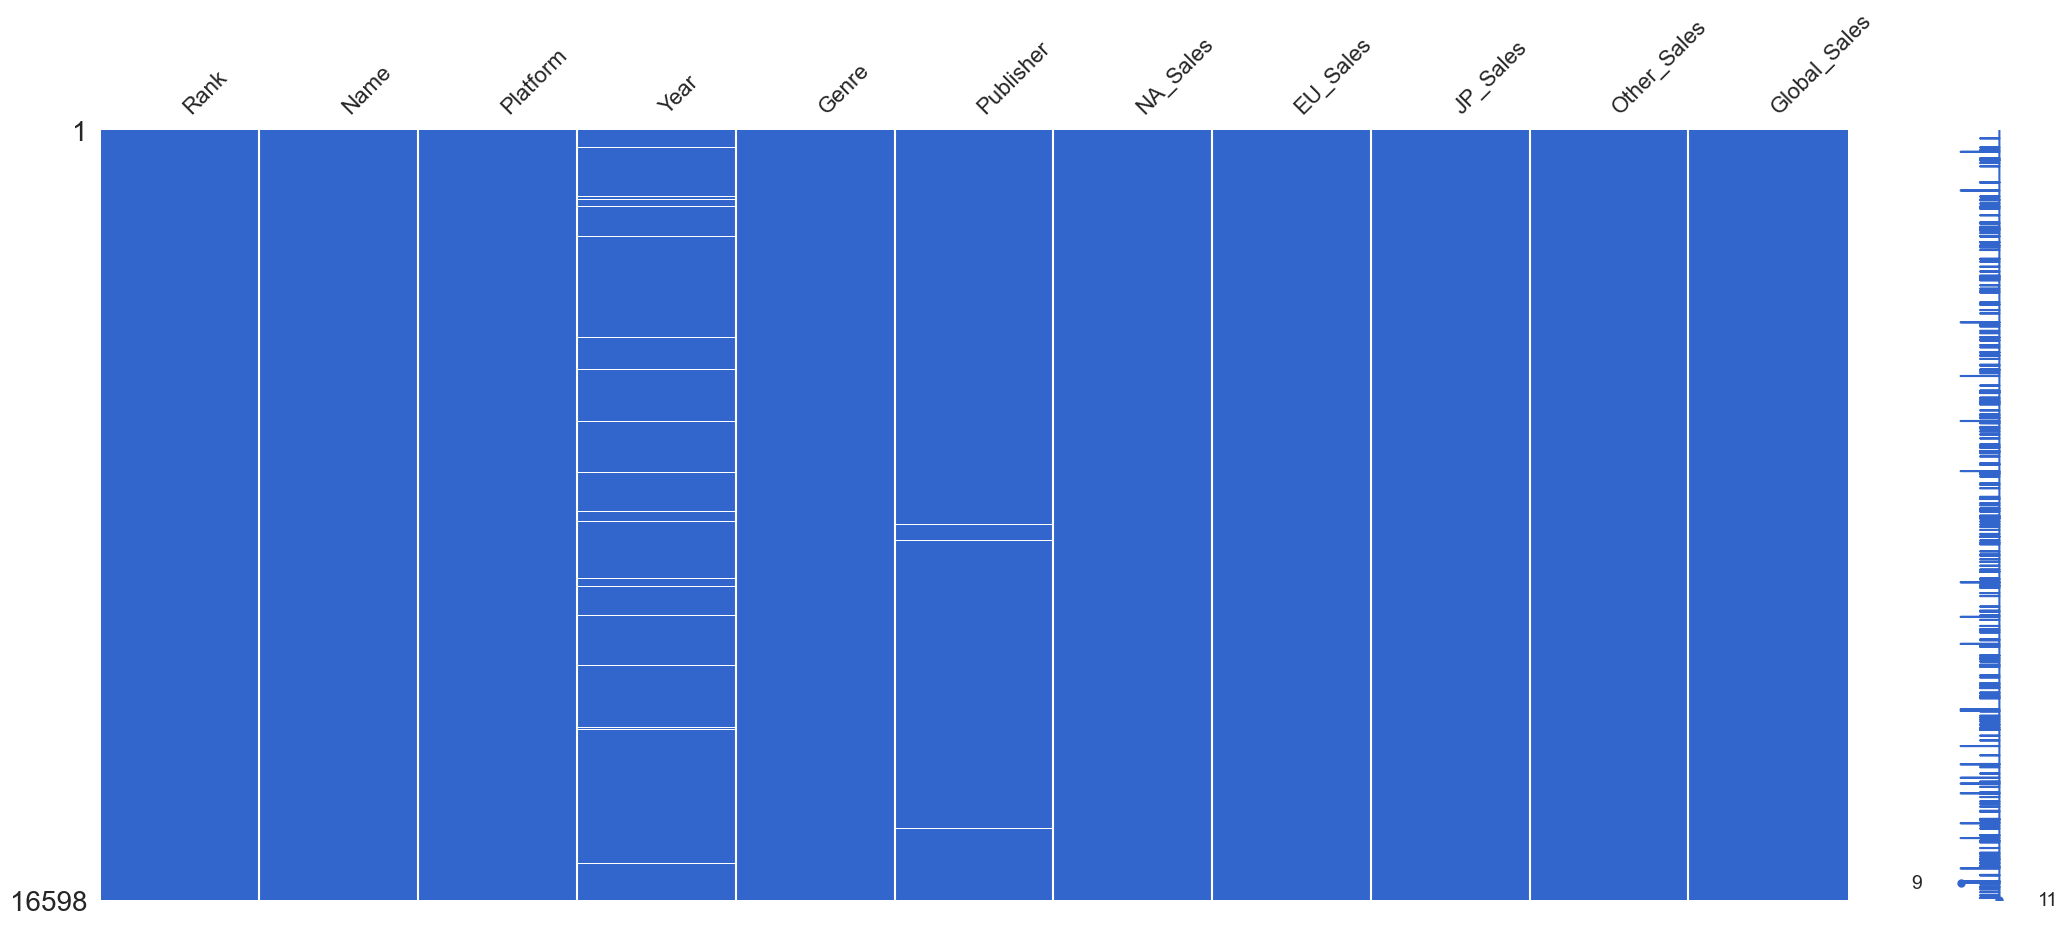

In [13]:
# Eksik veri kontrolü için missingno kütüphanesini kullanabilir
msno.matrix(data, color=(0.2, 0.4, 0.8))  
plt.show()


In [14]:
# Aykırı değer kontrolü ve düzenleme
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

for column in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']:
    handle_outliers(data, column)

In [15]:
# Oyunların piyasaya sürülme süresi ile ilgili bir özellik eklenmesi
data['Release_Year'] = pd.to_datetime(data['Year'], format='%Y')
data['Release_Month'] = data['Release_Year'].dt.month
data['Games_Per_Year'] = data.groupby('Year')['Name'].transform('count')

In [16]:
# Random Forest Regressor kullanımı
publisher_sales = data[data['Year'] < 2024].groupby(['Year', 'Publisher'])['Global_Sales'].sum().reset_index()
model = RandomForestRegressor(random_state=42)
X = publisher_sales[['Year']]
y = publisher_sales['Global_Sales']
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [17]:
# R-kare (coefficient of determination) değerini hesaplama
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R2 Score: {r2}")

R2 Score: 0.014081652993011562


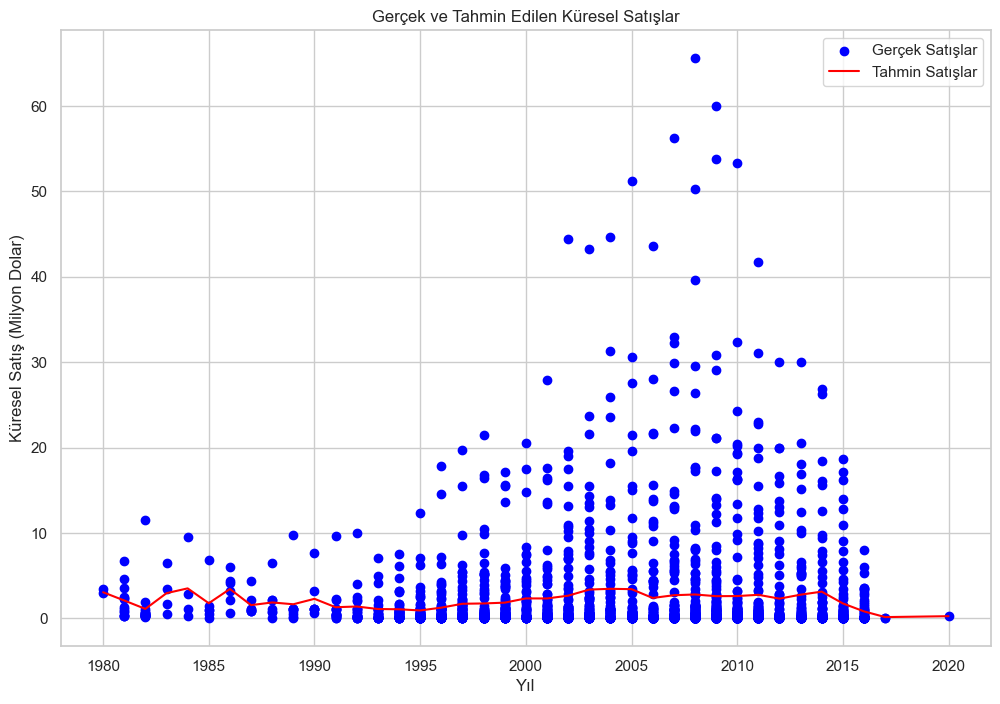

In [18]:
# Gerçek ve tahmin edilen satışları görselleştirme
plt.figure(figsize=(12, 8))
plt.scatter(publisher_sales['Year'], publisher_sales['Global_Sales'], color='b', label='Gerçek Satışlar')
plt.plot(publisher_sales['Year'], model.predict(X), color='r', label='Tahmin Satışlar')
plt.xlabel('Yıl')
plt.ylabel('Küresel Satış (Milyon Dolar)')
plt.title('Gerçek ve Tahmin Edilen Küresel Satışlar')
plt.legend()
plt.show()

In [19]:
# Yıllara göre satışları normalleştirmek için o yıl içindeki oyun sayısını kullanarak bir özellik ekleme
genre_sales = data[data['Year'] < 2024].groupby(['Genre'])['Global_Sales'].sum().reset_index()
X_cluster = genre_sales[['Global_Sales']]
kmeans = KMeans(n_clusters=3, random_state=42)
genre_sales['Cluster'] = kmeans.fit_predict(X_cluster)
silhouette_avg = silhouette_score(X_cluster, genre_sales['Cluster'])

print(f"Silhouette Score: {silhouette_avg}")

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.6201326700162646


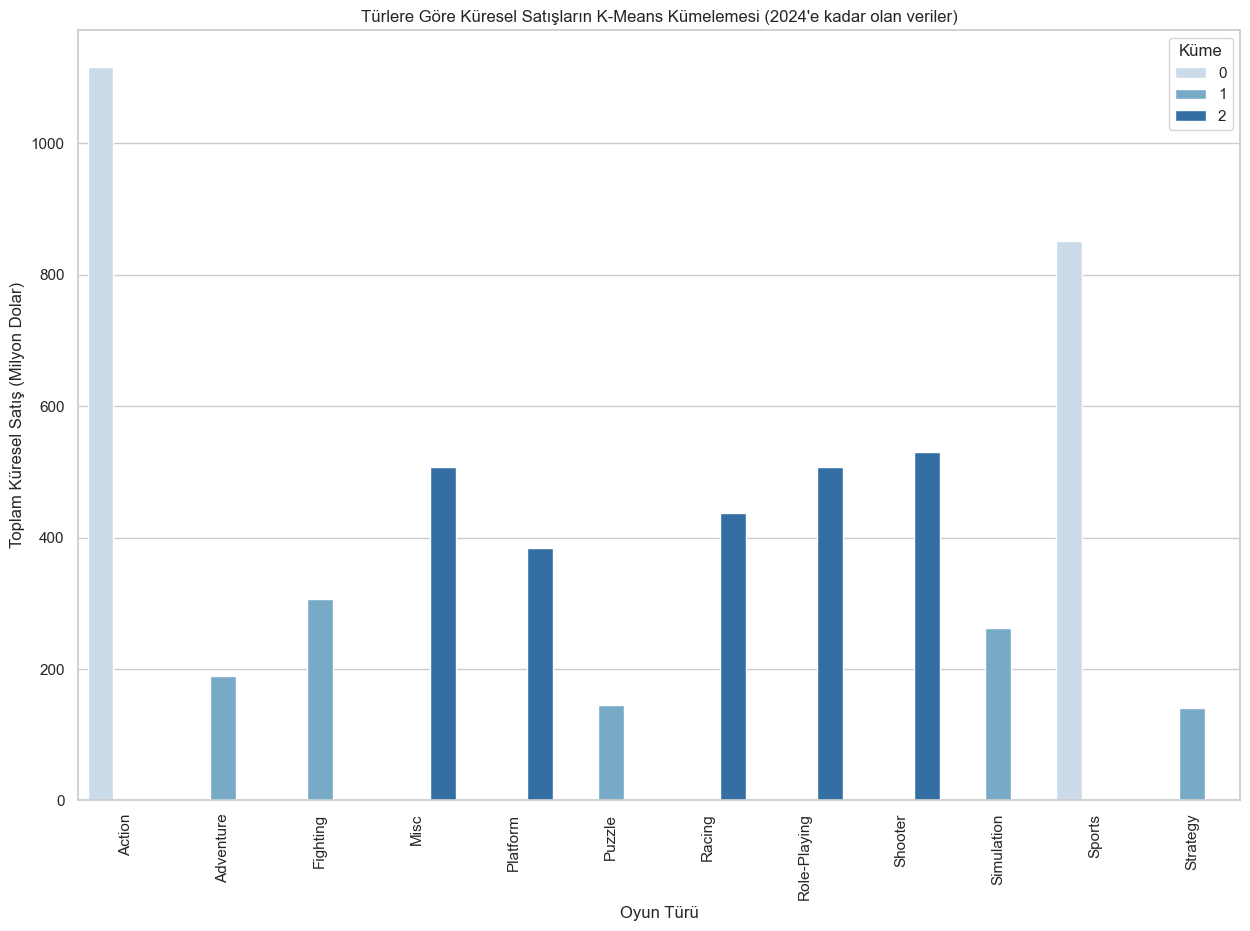

In [20]:
# Kümeleme sonuçlarını görselleştirme
plt.figure(figsize=(15, 10))
sns.barplot(x='Genre', y='Global_Sales', hue='Cluster', data=genre_sales, palette='Blues')
plt.title('Türlere Göre Küresel Satışların K-Means Kümelemesi (2024\'e kadar olan veriler)')
plt.xlabel('Oyun Türü')
plt.ylabel('Toplam Küresel Satış (Milyon Dolar)')
plt.legend(title='Küme')
plt.xticks(rotation=90)
plt.show()